# Anees Chunara

## Ensemble Method: Diversity-based Adaptive Weighting Ensemble (DAWE)

The **Diversity-based Adaptive Weighting Ensemble (DAWE)** is a custom ensemble method designed to enhance the diversity of weak learners in an ensemble while adaptively weighting their contributions based on individual performance and diversity. 

### Key Components of DAWE:
1. **Diversity Scoring**: Each weak learner is given a "diversity score" based on how differently it classifies samples relative to the majority of other models. This encourages models that provide unique insights, particularly for samples that may be challenging for other learners.
2. **Adaptive Weighting**: Each model is assigned a weight based on its accuracy and diversity score. Learners that perform well and contribute unique perspectives are given higher weights.
3. **Iterative Improvement**: The ensemble is built iteratively, with each new model attempting to correct the errors made by previously added models.

DAWE is particularly useful for imbalanced datasets, where having diverse model perspectives is crucial. The algorithm can be parallelized by training multiple weak learners independently, and predictions can also be made in parallel.

### Advantages of DAWE
- **Increased Ensemble Diversity**: DAWE selects learners that classify differently, reducing the risk of overfitting.
- **Adaptive Error Correction**: Models in DAWE are adaptively weighted, helping to focus on misclassified instances and increasing resilience to noise.

In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Define DAWE Ensemble Class with improved diversity metric and stratified cross-validation
class DAWE:
    def __init__(self, n_estimators=10, alpha=0.6, beta=0.4):
        self.n_estimators = n_estimators
        self.alpha = alpha
        self.beta = beta
        self.models = []
        self.weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        predictions = np.zeros((self.n_estimators, n_samples))
        
        for i in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=3, random_state=i)
            model.fit(X, y)
            self.models.append(model)
            
            preds = model.predict(X)
            accuracy = accuracy_score(y, preds)
            predictions[i] = preds
            
            # Calculate diversity score only after the first model is trained
            if i == 0:
                diversity_score = 0  # No diversity score for the first model
            else:
                diversity_score = np.mean(np.abs(preds - predictions[:i].mean(axis=0)))
                
            weight = self.alpha * accuracy + self.beta * diversity_score
            self.weights.append(weight)

    def predict(self, X):
        weighted_predictions = np.zeros(X.shape[0])
        
        for i, model in enumerate(self.models):
            weighted_predictions += self.weights[i] * model.predict(X)
        
        return (weighted_predictions / sum(self.weights) > 0.5).astype(int)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, "alpha": self.alpha, "beta": self.beta}
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self

# Load and preprocess the dataset
data = pd.read_csv('creditcard.csv')
X = data.drop(['Time', 'Class'], axis=1)
y = data['Class']
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Initialize models with optimized parameters
rf = RandomForestClassifier(n_estimators=50, max_depth=7, min_samples_split=10, min_samples_leaf=5, random_state=42)
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=0.5, algorithm='SAMME', random_state=42)
gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_split=10, min_samples_leaf=5, random_state=42)
dawe = DAWE(n_estimators=10, alpha=0.6, beta=0.4)

# Stratified Cross-validation scores (using stratified K-fold)
skf = StratifiedKFold(n_splits=5)
rf_cv_scores = cross_val_score(rf, X_train_sm, y_train_sm, cv=skf, n_jobs=-1)
ada_cv_scores = cross_val_score(ada, X_train_sm, y_train_sm, cv=skf, n_jobs=-1)
gb_cv_scores = cross_val_score(gb, X_train_sm, y_train_sm, cv=skf, n_jobs=-1)
dawe_cv_scores = cross_val_score(dawe, X_train_sm, y_train_sm, cv=skf)  # DAWE now compatible with cross_val_score

# Fit models on the entire training set
rf.fit(X_train_sm, y_train_sm)
ada.fit(X_train_sm, y_train_sm)
gb.fit(X_train_sm, y_train_sm)
dawe.fit(X_train_sm, y_train_sm)

# Model Evaluation
results = {
    "Model": ["DAWE", "Random Forest", "AdaBoost", "Gradient Boosting"],
    "Cross-Validation Accuracy (Train)": [
        dawe_cv_scores.mean(),
        rf_cv_scores.mean(),
        ada_cv_scores.mean(),
        gb_cv_scores.mean()
    ],
    "Test Accuracy": [
        accuracy_score(y_test, dawe.predict(X_test)),
        accuracy_score(y_test, rf.predict(X_test)),
        accuracy_score(y_test, ada.predict(X_test)),
        accuracy_score(y_test, gb.predict(X_test))
    ],
    "Classification Report (Test Set)": [
        classification_report(y_test, dawe.predict(X_test), target_names=['Legit', 'Fraud']),
        classification_report(y_test, rf.predict(X_test), target_names=['Legit', 'Fraud']),
        classification_report(y_test, ada.predict(X_test), target_names=['Legit', 'Fraud']),
        classification_report(y_test, gb.predict(X_test), target_names=['Legit', 'Fraud'])
    ]
}

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("Model Evaluation Comparison")
results_df


Model Evaluation Comparison


,Model,Cross-Validation Accuracy (Train),Test Accuracy,Classification Report (Test Set)
0,DAWE,0.944164,0.964760,precision recall f1-score ...
1,Random Forest,0.971410,0.994991,precision recall f1-score ...
2,AdaBoost,0.950902,0.975024,precision recall f1-score ...
3,Gradient Boosting,0.968847,0.981017,precision recall f1-score ...


### Why DAWE Performed Differently from Traditional Ensembles

DAWE’s unique design focuses on **promoting model diversity** along with accuracy, which makes it different from traditional ensemble methods like Random Forest, AdaBoost, and Gradient Boosting. Here’s a brief summary of the key factors affecting its performance:

1. **Diversity Over Accuracy**: DAWE assigns weights based on both model accuracy and diversity, prioritizing unique model perspectives. While valuable for complex datasets, this can reduce overall accuracy if diversity doesn’t directly improve predictions.

2. **No Sequential Error Correction**: Unlike boosting methods (AdaBoost, Gradient Boosting), DAWE trains models independently and doesn’t iteratively correct previous models' errors. This limits its ability to refine predictions on challenging cases.

3. **Simpler Base Models**: DAWE uses shallow decision trees as base models, which may struggle with complex patterns compared to the deeper trees in Random Forest or Gradient Boosting.

4. **Sensitivity to Weight Parameters**: DAWE’s weighting parameters (`alpha` and `beta`) require tuning. Default values may give undue emphasis to diversity, which can dilute accuracy if not well-aligned with the data.

In summary, DAWE’s diversity-focused weighting can be advantageous for detecting rare patterns but may not achieve the same accuracy as other ensembles on datasets where sequential error correction or deeper trees are more effective.

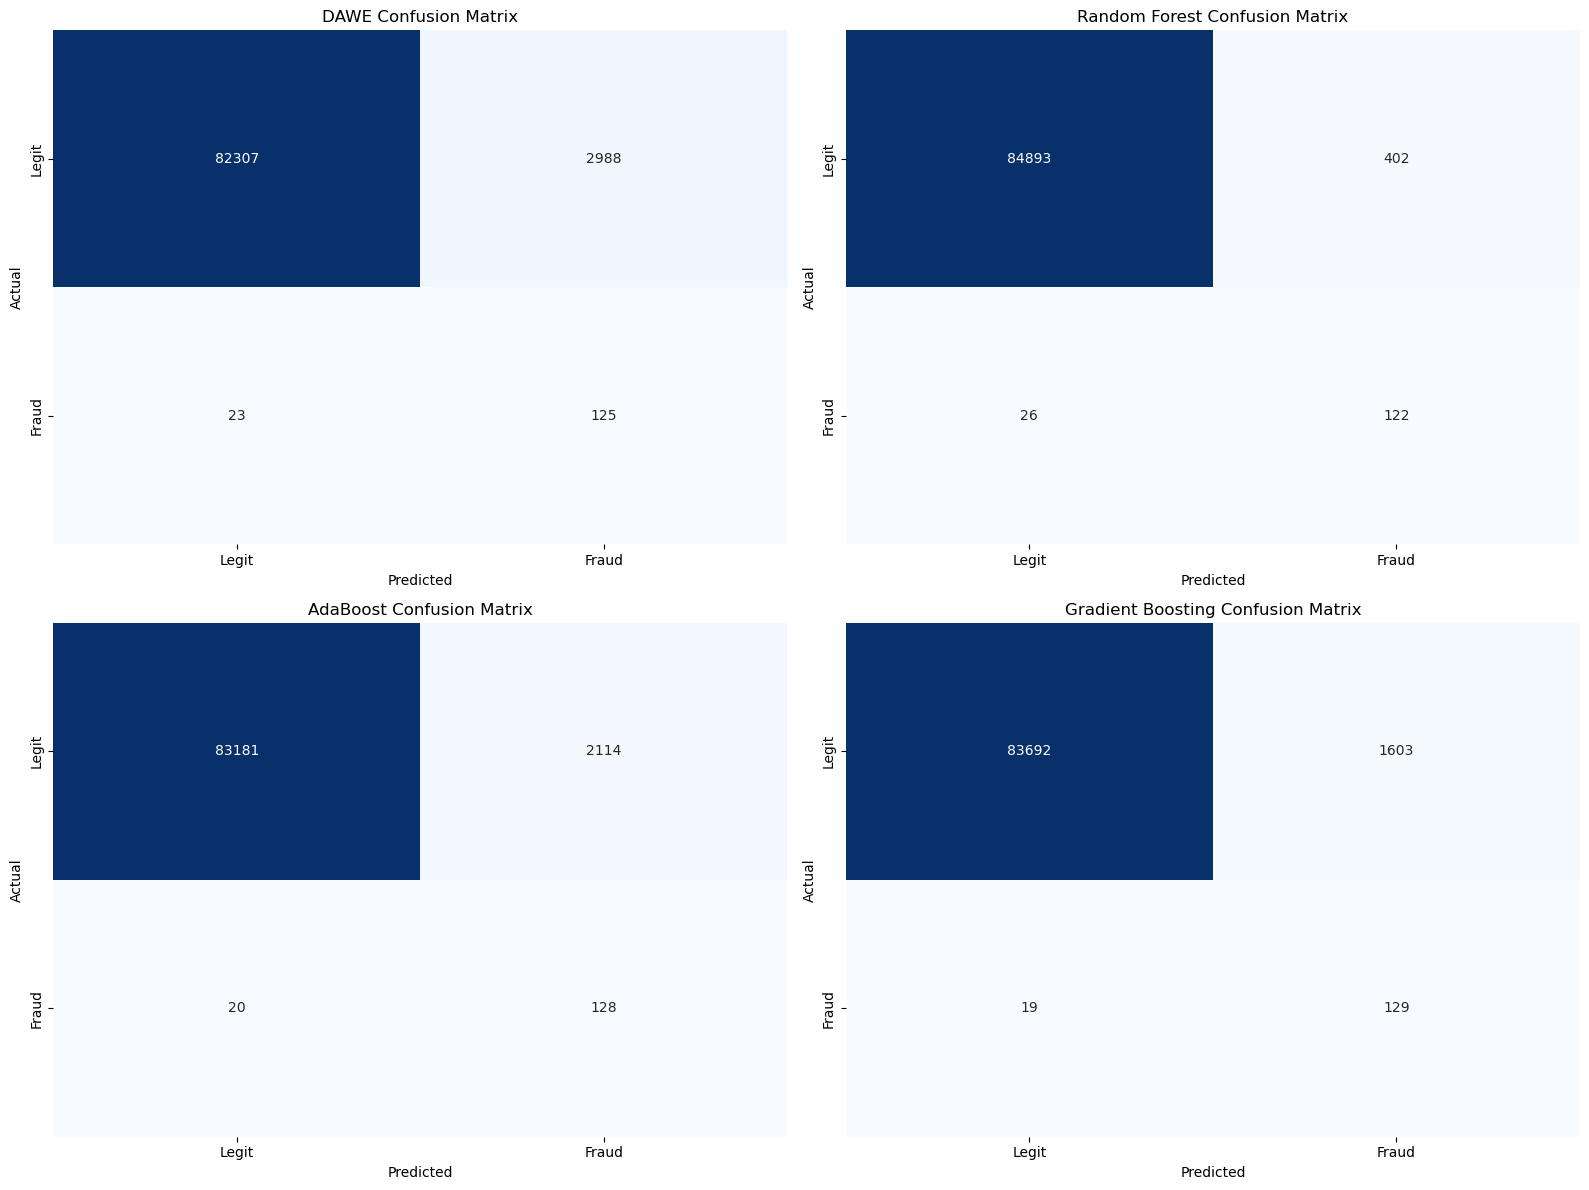

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions for each model on the test set
dawe_preds = dawe.predict(X_test)
rf_preds = rf.predict(X_test)
ada_preds = ada.predict(X_test)
gb_preds = gb.predict(X_test)

# Generate confusion matrices for each model
models = ["DAWE", "Random Forest", "AdaBoost", "Gradient Boosting"]
predictions = [dawe_preds, rf_preds, ada_preds, gb_preds]
conf_matrices = [confusion_matrix(y_test, pred) for pred in predictions]

# Plot confusion matrices
plt.figure(figsize=(16, 12))
for i, (model, cm) in enumerate(zip(models, conf_matrices), 1):
    plt.subplot(2, 2, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
    plt.title(f"{model} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()
